<div class="alert alert-info">
    <h3>Version Updates</h3>
    <ul>
        <li>Train Test Split for better Evaluation</li>
        <li><b>Transfer Learning</b> with EfficinetNetB0</li>
    </ul>
    
</div>

## Setup

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns



from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

import tensorflow as tf
import tensorflow_hub as hub
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.layers import Input, Activation, LeakyReLU, Dropout
from keras.losses import BinaryCrossentropy
try:
    from keras.optimizer import Adam
except:
    from tensorflow.keras.optimizers import Adam
    
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import warnings
warnings.filterwarnings('ignore')

MAIN_DIR = "basedata/"
SEED = 40

## Preparing the Image Data

In [3]:
os.listdir(MAIN_DIR)

['no', 'yes']

In [4]:
for dirpath,dirnames,filenames in os.walk(MAIN_DIR):
    print(f"{len(dirnames)} directories and {len(filenames)} images in {dirpath}")

2 directories and 0 images in basedata/
0 directories and 58 images in basedata/no
0 directories and 90 images in basedata/yes


In [5]:
# Inspect the raw data before preprocessing
def view_random_image():
    
    subdirs = ['yes/','no/']
    subdir = np.random.choice(subdirs)
    target_folder = MAIN_DIR + subdir
    
    random_image = random.sample(os.listdir(target_folder), 1)
    
    img = cv2.imread(target_folder+random_image[0])
    plt.imshow(img, cmap="gray")
    plt.axis(False)
    plt.title(img.shape)
    plt.show()

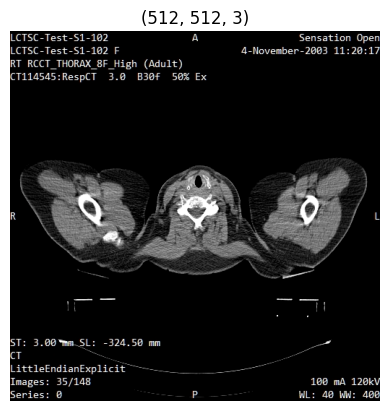

In [6]:
# View Random Image
view_random_image()

### Image Data Generator

In [7]:
IMG_SHAPE = (128,128)
BATCH_SIZE = 32

In [8]:
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split=0.5)
train_data = datagen.flow_from_directory(MAIN_DIR,
                                        target_size=IMG_SHAPE,
                                        batch_size=BATCH_SIZE,
                                        class_mode="binary",
                                        shuffle=True,
                                        subset="training")

test_data = datagen.flow_from_directory(MAIN_DIR,
                                       target_size=IMG_SHAPE,
                                       batch_size=BATCH_SIZE,
                                       class_mode="binary",
                                       shuffle=True,
                                       subset="validation")

Found 74 images belonging to 2 classes.
Found 74 images belonging to 2 classes.


In [9]:
len(train_data), len(test_data)

(3, 3)

## Convolutional Neural Network

In [10]:
tf.random.set_seed(SEED)

model = Sequential([
    Conv2D(filters=64,
           kernel_size=3,
           activation='relu'),
    Conv2D(32,3,activation='relu'),
    MaxPool2D(pool_size=2),
    Conv2D(32,3,activation='relu'),
    Conv2D(16,3,activation='relu'),
    MaxPool2D(2, padding='same'),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(),
              metrics=["accuracy"])

# Fit the model
history = model.fit(train_data,
                    epochs=10,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Epoch 1/10
3/3 [==============================] - 3s 913ms/step - loss: 0.6491 - accuracy: 0.6081 - val_loss: 0.6422 - val_accuracy: 0.6081
Epoch 2/10
3/3 [==============================] - 2s 586ms/step - loss: 0.4894 - accuracy: 0.7838 - val_loss: 0.5427 - val_accuracy: 0.8108
Epoch 3/10
3/3 [==============================] - 2s 569ms/step - loss: 0.2726 - accuracy: 1.0000 - val_loss: 0.5089 - val_accuracy: 0.7703
Epoch 4/10
3/3 [==============================] - 2s 776ms/step - loss: 0.0201 - accuracy: 1.0000 - val_loss: 0.6552 - val_accuracy: 0.8108
Epoch 5/10
3/3 [==============================] - 2s 563ms/step - loss: 5.2230e-04 - accuracy: 1.0000 - val_loss: 0.7870 - val_accuracy: 0.7973
Epoch 6/10
3/3 [==============================] - 2s 576ms/step - loss: 8.0185e-06 - accuracy: 1.0000 - val_loss: 0.9498 - val_accuracy: 0.7703
Epoch 7/10
3/3 [==============================] - 2s 796ms/step - loss: 3.4336e-07 - accuracy: 1.0000 - val_loss: 1.1212 - val_accuracy: 0.7838
Epoch 8/

## Evaluation

In [11]:
# Function to plot loss curves
def plot_curves(history):

    """
    Returns separate loss and accuracy curves
    """
    import matplotlib.pyplot as plt

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

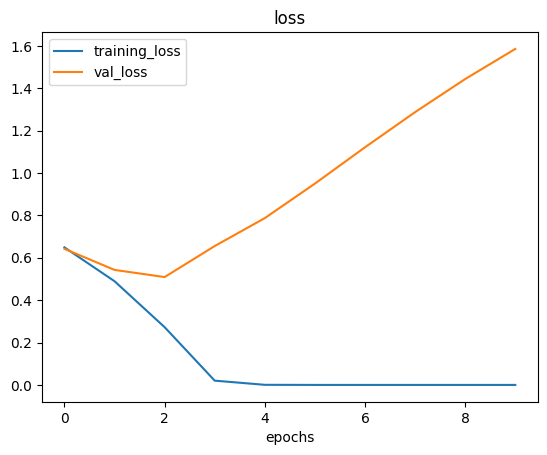

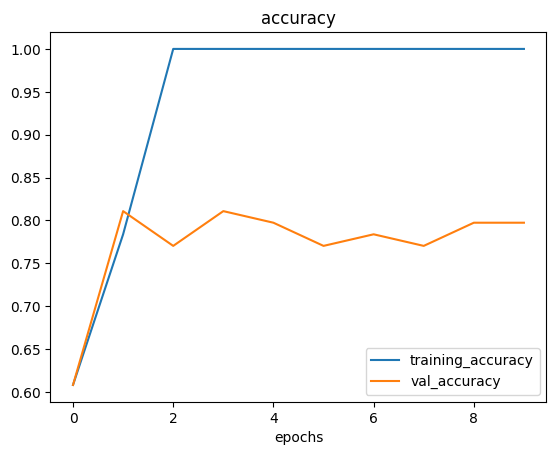

In [12]:
plot_curves(history)

In [13]:
result = model.evaluate(test_data, verbose=0)
print(f"Accuracy on Evaluation: {result[1]*100:.2f}%\nLoss: {result[0]:.4f}")

Accuracy on Evaluation: 79.73%
Loss: 1.5853
